In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [17]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [18]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [19]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
PAAD     171
ESCA     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [20]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [21]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()

111

112

In [22]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM') & (samples['project']=='BRCA')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM') & (samples['project']=='BRCA')]
#cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases.shape

(116,)

In [23]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [24]:
case_tumor.shape
case_norm.shape
cases.shape

(116, 10)

(111, 10)

(227, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          90
Solid Tissue Normal    80
Name: Sample Type, dtype: int64

Solid Tissue Normal    31
Primary Tumor          26
Name: Sample Type, dtype: int64

In [11]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [12]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [39]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [40]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/170 (0%)]	Loss: 0.309576
Epoch: 1/20. Train set: Average loss: 0.1339
Epoch: 1/20. Validation set: Average loss: 0.2022
Train: [0/170 (0%)]	Loss: 0.159153
Epoch: 2/20. Train set: Average loss: 5.2634
Epoch: 2/20. Validation set: Average loss: 3.8425
Train: [0/170 (0%)]	Loss: 0.058472
Epoch: 3/20. Train set: Average loss: 31.0836
Epoch: 3/20. Validation set: Average loss: 23.4771
Train: [0/170 (0%)]	Loss: 0.396787
Epoch: 4/20. Train set: Average loss: 1.9294
Epoch: 4/20. Validation set: Average loss: 26.6597
Train: [0/170 (0%)]	Loss: 10.496665
Epoch: 5/20. Train set: Average loss: 22.8411
Epoch: 5/20. Validation set: Average loss: 23.3397
Train: [0/170 (0%)]	Loss: 19.739141
Epoch: 6/20. Train set: Average loss: 12.6776
Epoch: 6/20. Validation set: Average loss: 345.2364
Train: [0/170 (0%)]	Loss: 24.118319
Epoch: 7/20. Train set: Average loss: 40.0335
Epoch: 7/20. Validation set: Average loss: 11.5254
Train: [0/170 (0%)]	Loss: 9.543568
Epoch: 8/20. Train set: Average loss: 2.88

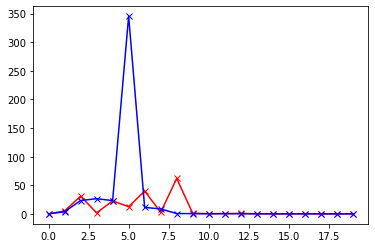

In [41]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

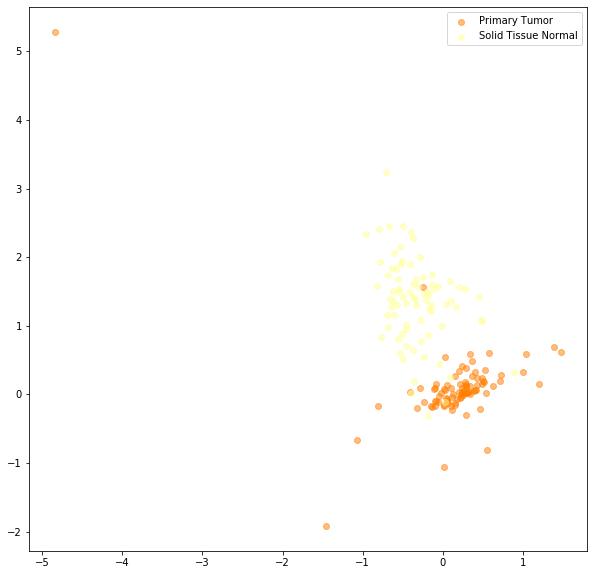

In [42]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

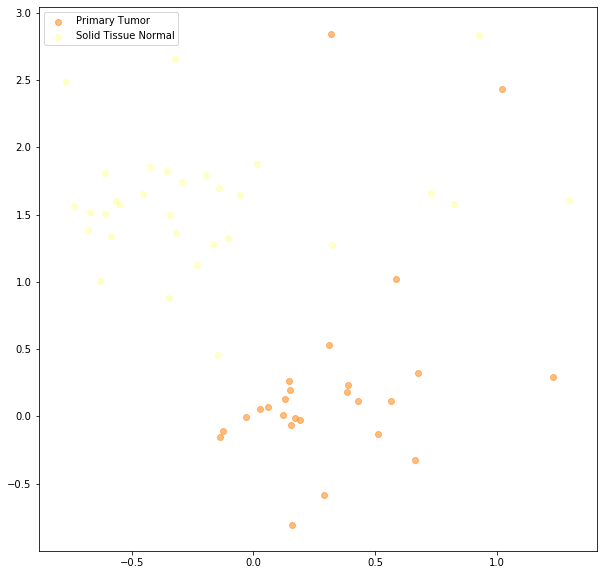

In [43]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [44]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

In [45]:
tmp_model = copy.deepcopy(model)

In [46]:
tmp_model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [47]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

### IG with Control vector

In [48]:
ctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [49]:
ig = IntegratedGradients(tmp_model.get_embedding)

In [63]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

(28, 60483)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb78d2e2cf8>]],
      dtype=object)

,Attribution
count,60483.000000
mean,0.000011
std,0.000819
min,-0.028703
25%,-0.000017
50%,0.000000
75%,0.000025
max,0.172529


,Attribution
0,
ENSG00000249557.2,0.172529
ENSG00000230014.1,0.074307
ENSG00000215182.8,0.045812
ENSG00000258991.1,0.014912
ENSG00000271307.1,0.012970
ENSG00000273906.1,0.011536
ENSG00000258567.1,0.007213
ENSG00000124812.13,0.006957
ENSG00000221747.1,0.006162


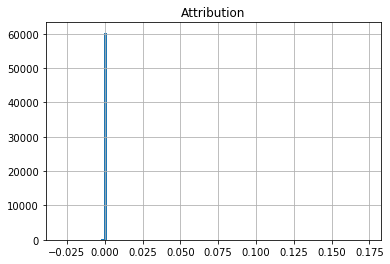

In [64]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

### Test completeness axiom
- Euclidean Distance between samples
- feature attribution sum
- difference between

In [52]:
pdist = torch.nn.PairwiseDistance(p=2)
outdist = pdist(exp_data, ctrl_data)

diff = np.round(outdist.detach().numpy() - attr.sum(axis=1), 3)
diff.mean(); np.median(diff); diff.var()

1542.0985

624.604

9738514.0

#### Inspect individual sample attributions

In [54]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)

0
ENSG00000229028.2    0.055757
ENSG00000187242.4    0.041264
ENSG00000228221.4    0.012785
ENSG00000277969.1    0.012117
ENSG00000169962.4    0.007715
ENSG00000274244.1    0.007210
ENSG00000198754.5    0.007103
ENSG00000264808.1    0.006721
ENSG00000228561.2    0.006233
ENSG00000263874.1    0.006038
dtype: float32

0
ENSG00000215182.8     0.497859
ENSG00000235343.1     0.014349
ENSG00000163993.6     0.011165
ENSG00000173898.10    0.006615
ENSG00000101977.18    0.006103
ENSG00000265043.1     0.005533
ENSG00000173715.14    0.005059
ENSG00000236345.1     0.004793
ENSG00000173992.7     0.003258
ENSG00000182791.4     0.003228
dtype: float32

0
ENSG00000237256.1     0.061887
ENSG00000236385.1     0.017955
ENSG00000167165.17    0.009618
ENSG00000274246.1     0.008147
ENSG00000225538.1     0.005702
ENSG00000216072.2     0.005669
ENSG00000248114.1     0.005575
ENSG00000227802.1     0.004984
ENSG00000228561.2     0.004599
ENSG00000276688.1     0.004134
dtype: float32

0
ENSG00000273609.1     0.011800
ENSG00000270444.1     0.008676
ENSG00000249689.1     0.004973
ENSG00000265330.1     0.004029
ENSG00000226112.1     0.003720
ENSG00000227537.1     0.003519
ENSG00000232294.4     0.003455
ENSG00000254376.2     0.002981
ENSG00000148942.13    0.002951
ENSG00000275287.3     0.002783
dtype: float32

0
ENSG00000179046.7     0.023966
ENSG00000280142.1     0.016585
ENSG00000272763.1     0.012186
ENSG00000122585.6     0.012116
ENSG00000125046.13    0.011479
ENSG00000210741.1     0.009480
ENSG00000224865.6     0.008601
ENSG00000254083.4     0.008471
ENSG00000229310.1     0.007985
ENSG00000226412.1     0.007001
dtype: float32

0
ENSG00000215182.8     0.786968
ENSG00000273906.1     0.076164
ENSG00000173898.10    0.028045
ENSG00000143512.11    0.027958
ENSG00000232715.1     0.017584
ENSG00000253160.1     0.017215
ENSG00000223018.1     0.017017
ENSG00000173715.14    0.016662
ENSG00000188997.6     0.013040
ENSG00000182791.4     0.012114
dtype: float32

0
ENSG00000230014.1    2.082121
ENSG00000271307.1    0.363154
ENSG00000241280.1    0.040067
ENSG00000280140.1    0.040031
ENSG00000274269.1    0.030065
ENSG00000228695.8    0.028297
ENSG00000182459.4    0.014842
ENSG00000215811.5    0.014505
ENSG00000215612.6    0.014247
ENSG00000237617.1    0.012008
dtype: float32

0
ENSG00000249557.2     2.440533
ENSG00000233258.1     0.060956
ENSG00000229982.1     0.046288
ENSG00000254842.5     0.037765
ENSG00000225537.1     0.031710
ENSG00000242262.1     0.028337
ENSG00000186493.10    0.018019
ENSG00000279773.1     0.015969
ENSG00000222418.1     0.015838
ENSG00000260742.1     0.014066
dtype: float32

0
ENSG00000230339.2     0.005144
ENSG00000277212.1     0.002396
ENSG00000205449.10    0.002261
ENSG00000259890.1     0.001950
ENSG00000264545.1     0.001914
ENSG00000146910.10    0.001700
ENSG00000279697.1     0.001697
ENSG00000241317.1     0.001508
ENSG00000257737.1     0.001457
ENSG00000275508.1     0.001454
dtype: float32

0
ENSG00000268089.2    0.048089
ENSG00000215644.8    0.032105
ENSG00000241244.1    0.020868
ENSG00000231694.1    0.018755
ENSG00000249082.2    0.018087
ENSG00000236387.1    0.016549
ENSG00000253818.1    0.013342
ENSG00000277683.1    0.013202
ENSG00000275958.1    0.012093
ENSG00000280412.1    0.011640
dtype: float32

0
ENSG00000263566.1     0.012555
ENSG00000270242.1     0.008138
ENSG00000230051.1     0.007019
ENSG00000279666.1     0.006710
ENSG00000182634.7     0.005866
ENSG00000131686.13    0.004718
ENSG00000260289.1     0.004706
ENSG00000278568.1     0.004441
ENSG00000207101.1     0.004318
ENSG00000249764.1     0.004286
dtype: float32

0
ENSG00000006611.14    0.103996
ENSG00000210741.1     0.092754
ENSG00000272763.1     0.032420
ENSG00000231419.5     0.030909
ENSG00000223414.2     0.019305
ENSG00000215124.2     0.017823
ENSG00000006016.9     0.011291
ENSG00000141639.10    0.010316
ENSG00000253262.1     0.010221
ENSG00000237266.1     0.010218
dtype: float32

0
ENSG00000258991.1    0.414562
ENSG00000258567.1    0.201304
ENSG00000221747.1    0.172546
ENSG00000274773.1    0.131939
ENSG00000277716.1    0.088296
ENSG00000276079.1    0.084267
ENSG00000144771.7    0.058227
ENSG00000273534.1    0.047707
ENSG00000259029.1    0.027243
ENSG00000250976.1    0.021670
dtype: float32

0
ENSG00000184672.10    0.008777
ENSG00000248646.1     0.007554
ENSG00000186710.10    0.007302
ENSG00000226321.5     0.006113
ENSG00000221741.1     0.005160
ENSG00000246016.2     0.004910
ENSG00000176601.10    0.004513
ENSG00000243910.6     0.004383
ENSG00000164287.11    0.004363
ENSG00000187492.7     0.004083
dtype: float32

0
ENSG00000273906.1     0.079653
ENSG00000232294.4     0.018214
ENSG00000229755.1     0.014848
ENSG00000226975.1     0.010410
ENSG00000204983.11    0.010020
ENSG00000175121.10    0.009168
ENSG00000183971.5     0.009145
ENSG00000254320.1     0.008332
ENSG00000148942.13    0.007678
ENSG00000181588.16    0.006958
dtype: float32

0
ENSG00000201938.1    0.005626
ENSG00000270962.1    0.005310
ENSG00000257404.1    0.004728
ENSG00000241059.2    0.004572
ENSG00000201604.1    0.004335
ENSG00000271343.1    0.004297
ENSG00000274459.1    0.004226
ENSG00000206867.1    0.003949
ENSG00000278568.1    0.003939
ENSG00000265662.1    0.003447
dtype: float32

0
ENSG00000124812.13    0.190407
ENSG00000256148.1     0.009826
ENSG00000267094.1     0.009687
ENSG00000280707.1     0.008254
ENSG00000236107.6     0.007459
ENSG00000233296.1     0.006936
ENSG00000210741.1     0.006676
ENSG00000276951.1     0.005548
ENSG00000238062.4     0.005089
ENSG00000272763.1     0.004974
dtype: float32

0
ENSG00000089116.3     0.016876
ENSG00000156510.12    0.014353
ENSG00000117148.7     0.011691
ENSG00000128714.5     0.010297
ENSG00000275451.1     0.009936
ENSG00000258381.1     0.009441
ENSG00000232817.1     0.008681
ENSG00000172116.20    0.008141
ENSG00000257470.1     0.007666
ENSG00000280411.1     0.007172
dtype: float32

0
ENSG00000255079.1     0.017347
ENSG00000211917.1     0.011017
ENSG00000253862.1     0.010646
ENSG00000203645.2     0.010359
ENSG00000255051.1     0.009658
ENSG00000215398.10    0.008754
ENSG00000248538.5     0.008401
ENSG00000224028.1     0.008229
ENSG00000211920.1     0.007319
ENSG00000109208.4     0.006595
dtype: float32

0
ENSG00000179046.7     0.013654
ENSG00000126550.7     0.008193
ENSG00000280142.1     0.007658
ENSG00000272763.1     0.006648
ENSG00000166589.11    0.005890
ENSG00000131737.5     0.005543
ENSG00000125046.13    0.005330
ENSG00000029559.6     0.005293
ENSG00000137673.7     0.004387
ENSG00000224865.6     0.004210
dtype: float32

0
ENSG00000242262.1    0.004693
ENSG00000278568.1    0.002893
ENSG00000270242.1    0.002729
ENSG00000263566.1    0.002637
ENSG00000221602.1    0.002622
ENSG00000182634.7    0.002612
ENSG00000265567.1    0.002147
ENSG00000268412.2    0.002024
ENSG00000265364.1    0.002001
ENSG00000275075.1    0.001991
dtype: float32

0
ENSG00000230628.1    0.007741
ENSG00000221072.1    0.006242
ENSG00000278642.1    0.005447
ENSG00000180424.6    0.005162
ENSG00000228044.2    0.004646
ENSG00000223976.1    0.004583
ENSG00000105205.6    0.003952
ENSG00000261014.1    0.003592
ENSG00000267683.1    0.003273
ENSG00000281018.1    0.003230
dtype: float32

0
ENSG00000255079.1     0.024416
ENSG00000203645.2     0.017106
ENSG00000255051.1     0.016555
ENSG00000253862.1     0.016121
ENSG00000211917.1     0.015363
ENSG00000215398.10    0.014777
ENSG00000224028.1     0.014494
ENSG00000248538.5     0.012676
ENSG00000211920.1     0.011504
ENSG00000211819.3     0.010677
dtype: float32

0
ENSG00000249557.2     2.389041
ENSG00000273906.1     0.167752
ENSG00000233258.1     0.056496
ENSG00000229982.1     0.043094
ENSG00000254842.5     0.033558
ENSG00000225537.1     0.028073
ENSG00000186493.10    0.016698
ENSG00000279773.1     0.016119
ENSG00000250418.1     0.014656
ENSG00000222418.1     0.014053
dtype: float32

0
ENSG00000230628.1    0.008127
ENSG00000180424.6    0.006386
ENSG00000278642.1    0.005186
ENSG00000228044.2    0.004984
ENSG00000229183.7    0.003759
ENSG00000252545.1    0.003695
ENSG00000241475.1    0.003231
ENSG00000200026.1    0.003210
ENSG00000239028.1    0.003123
ENSG00000264092.2    0.002893
dtype: float32

0
ENSG00000232294.4     0.005314
ENSG00000175121.10    0.004666
ENSG00000226975.1     0.004140
ENSG00000254320.1     0.003091
ENSG00000229755.1     0.002937
ENSG00000225741.1     0.002793
ENSG00000204983.11    0.002641
ENSG00000183971.5     0.002616
ENSG00000215943.1     0.002516
ENSG00000105464.3     0.002459
dtype: float32

0
ENSG00000184672.10    0.007480
ENSG00000186710.10    0.006431
ENSG00000248646.1     0.005963
ENSG00000226321.5     0.004758
ENSG00000246016.2     0.004344
ENSG00000221741.1     0.004322
ENSG00000176601.10    0.003969
ENSG00000243910.6     0.003616
ENSG00000140481.12    0.003384
ENSG00000187492.7     0.003336
dtype: float32

0
ENSG00000221287.1     0.021841
ENSG00000253345.1     0.019807
ENSG00000253860.1     0.019555
ENSG00000232216.1     0.018365
ENSG00000049247.12    0.015884
ENSG00000253497.1     0.014597
ENSG00000166926.7     0.012992
ENSG00000276566.1     0.012984
ENSG00000260879.1     0.012901
ENSG00000241566.1     0.012663
dtype: float32

In [65]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nsmallest(10)

0
ENSG00000258115.1   -0.020153
ENSG00000226374.1   -0.013078
ENSG00000233494.1   -0.010390
ENSG00000227425.1   -0.009856
ENSG00000231894.1   -0.009350
ENSG00000275138.1   -0.006200
ENSG00000225036.1   -0.006060
ENSG00000202398.1   -0.005658
ENSG00000234723.1   -0.005407
ENSG00000261595.1   -0.005391
dtype: float32

0
ENSG00000096006.10   -0.051280
ENSG00000226707.1    -0.005662
ENSG00000244619.2    -0.004841
ENSG00000143512.11   -0.004517
ENSG00000221287.1    -0.004366
ENSG00000264295.1    -0.002291
ENSG00000161055.3    -0.002115
ENSG00000182256.11   -0.002097
ENSG00000174080.9    -0.002042
ENSG00000232756.1    -0.001683
dtype: float32

0
ENSG00000232188.1    -0.092254
ENSG00000241635.6    -0.024769
ENSG00000224814.1    -0.022001
ENSG00000172296.11   -0.010962
ENSG00000243135.4    -0.009937
ENSG00000249425.1    -0.009781
ENSG00000224711.1    -0.008233
ENSG00000240584.3    -0.007786
ENSG00000198452.6    -0.006907
ENSG00000224625.2    -0.006817
dtype: float32

0
ENSG00000253968.1   -0.033750
ENSG00000277876.1   -0.005581
ENSG00000234670.1   -0.003152
ENSG00000158480.9   -0.002954
ENSG00000123584.7   -0.002924
ENSG00000275958.1   -0.002655
ENSG00000274028.1   -0.002271
ENSG00000277950.1   -0.002268
ENSG00000156575.2   -0.002252
ENSG00000249513.2   -0.002225
dtype: float32

0
ENSG00000105550.7    -0.056318
ENSG00000111700.11   -0.029090
ENSG00000131737.5    -0.028118
ENSG00000237153.1    -0.014026
ENSG00000255271.1    -0.013234
ENSG00000222236.1    -0.011507
ENSG00000254925.1    -0.010706
ENSG00000240611.1    -0.009435
ENSG00000126550.7    -0.009384
ENSG00000253275.1    -0.009023
dtype: float32

0
ENSG00000233070.1    -0.266600
ENSG00000229308.1    -0.148068
ENSG00000092377.12   -0.133492
ENSG00000229236.1    -0.047350
ENSG00000235343.1    -0.044474
ENSG00000231535.4    -0.032928
ENSG00000226863.1    -0.029697
ENSG00000176728.6    -0.029500
ENSG00000237659.1    -0.028955
ENSG00000227447.1    -0.025504
dtype: float32

0
ENSG00000162621.6    -0.032625
ENSG00000251297.1    -0.026464
ENSG00000125895.5    -0.017651
ENSG00000205745.2    -0.013172
ENSG00000261078.1    -0.012770
ENSG00000142609.16   -0.012247
ENSG00000201095.1    -0.012151
ENSG00000151458.10   -0.011269
ENSG00000164125.14   -0.010430
ENSG00000279139.1    -0.009406
dtype: float32

0
ENSG00000230720.1    -0.029059
ENSG00000256321.4    -0.026554
ENSG00000115934.11   -0.026180
ENSG00000263734.1    -0.023048
ENSG00000238819.1    -0.021945
ENSG00000219784.2    -0.017871
ENSG00000186925.6    -0.017144
ENSG00000213747.2    -0.015925
ENSG00000181325.7    -0.015565
ENSG00000223360.1    -0.015178
dtype: float32

0
ENSG00000230418.2   -0.003982
ENSG00000253501.1   -0.002726
ENSG00000232749.2   -0.002087
ENSG00000235976.2   -0.001952
ENSG00000223629.1   -0.001886
ENSG00000278757.1   -0.001576
ENSG00000201095.1   -0.001335
ENSG00000241392.3   -0.001320
ENSG00000270912.1   -0.001293
ENSG00000267251.2   -0.001274
dtype: float32

0
ENSG00000280614.1   -0.200490
ENSG00000258417.3   -0.172212
ENSG00000272558.1   -0.047141
ENSG00000202144.1   -0.027055
ENSG00000241457.1   -0.022308
ENSG00000271220.1   -0.015240
ENSG00000223691.1   -0.012740
ENSG00000186925.6   -0.012453
ENSG00000186970.4   -0.012291
ENSG00000234270.1   -0.010622
dtype: float32

0
ENSG00000203972.8    -0.009966
ENSG00000258567.1    -0.005098
ENSG00000231583.1    -0.004437
ENSG00000236190.1    -0.004403
ENSG00000182070.4    -0.004093
ENSG00000258383.1    -0.003919
ENSG00000171487.13   -0.003812
ENSG00000079156.15   -0.003803
ENSG00000237850.6    -0.003775
ENSG00000207758.1    -0.003648
dtype: float32

0
ENSG00000163283.6    -0.059504
ENSG00000110680.11   -0.050913
ENSG00000242207.1    -0.040723
ENSG00000158764.6    -0.035041
ENSG00000222236.1    -0.021002
ENSG00000150201.13   -0.019247
ENSG00000188162.9    -0.016482
ENSG00000254925.1    -0.015446
ENSG00000253275.1    -0.013005
ENSG00000142549.9    -0.012827
dtype: float32

0
ENSG00000259154.1   -0.088255
ENSG00000221134.1   -0.053648
ENSG00000223291.1   -0.032669
ENSG00000243715.1   -0.032111
ENSG00000276695.1   -0.028238
ENSG00000243799.1   -0.020042
ENSG00000238051.1   -0.017854
ENSG00000202498.1   -0.017320
ENSG00000198982.3   -0.016304
ENSG00000231411.1   -0.016038
dtype: float32

0
ENSG00000224920.1   -0.011113
ENSG00000241634.1   -0.010374
ENSG00000265015.1   -0.008740
ENSG00000236012.2   -0.002961
ENSG00000277515.1   -0.002750
ENSG00000203685.8   -0.002603
ENSG00000238764.1   -0.002569
ENSG00000200572.1   -0.002302
ENSG00000162685.6   -0.002178
ENSG00000275411.1   -0.002175
dtype: float32

0
ENSG00000233070.1    -0.171068
ENSG00000253968.1    -0.109962
ENSG00000229308.1    -0.108614
ENSG00000092377.12   -0.085090
ENSG00000229236.1    -0.036187
ENSG00000231535.4    -0.026883
ENSG00000226863.1    -0.026653
ENSG00000227447.1    -0.020328
ENSG00000237659.1    -0.019410
ENSG00000176728.6    -0.019255
dtype: float32

0
ENSG00000263566.1   -0.011253
ENSG00000268711.1   -0.008998
ENSG00000201923.1   -0.005751
ENSG00000264030.2   -0.005312
ENSG00000207101.1   -0.005304
ENSG00000229142.1   -0.003694
ENSG00000243669.2   -0.003564
ENSG00000260289.1   -0.003535
ENSG00000270242.1   -0.003142
ENSG00000258970.1   -0.002992
dtype: float32

0
ENSG00000256709.2   -0.014481
ENSG00000233970.1   -0.010687
ENSG00000223648.3   -0.009072
ENSG00000253555.1   -0.005365
ENSG00000253901.1   -0.005109
ENSG00000267012.1   -0.005061
ENSG00000267489.2   -0.004894
ENSG00000267664.1   -0.004335
ENSG00000229769.2   -0.004297
ENSG00000217707.2   -0.004172
dtype: float32

0
ENSG00000254407.1   -0.033035
ENSG00000225036.1   -0.019394
ENSG00000237197.1   -0.011764
ENSG00000276366.1   -0.011574
ENSG00000257691.2   -0.010197
ENSG00000257935.2   -0.009377
ENSG00000227244.2   -0.008596
ENSG00000239320.1   -0.008568
ENSG00000211911.1   -0.008223
ENSG00000205835.7   -0.006802
dtype: float32

0
ENSG00000259094.1    -0.103273
ENSG00000254220.1    -0.011670
ENSG00000225036.1    -0.008860
ENSG00000231586.2    -0.008588
ENSG00000197273.3    -0.008558
ENSG00000264108.1    -0.008401
ENSG00000230973.1    -0.008185
ENSG00000260476.1    -0.007725
ENSG00000275138.1    -0.007546
ENSG00000177504.10   -0.007539
dtype: float32

0
ENSG00000105550.7    -0.020872
ENSG00000223716.2    -0.008421
ENSG00000255271.1    -0.007215
ENSG00000237153.1    -0.006637
ENSG00000111700.11   -0.006185
ENSG00000274694.1    -0.003645
ENSG00000188581.8    -0.003498
ENSG00000263590.2    -0.003149
ENSG00000233085.4    -0.003117
ENSG00000272456.1    -0.002722
dtype: float32

0
ENSG00000230720.1   -0.005916
ENSG00000181325.7   -0.002325
ENSG00000263734.1   -0.002252
ENSG00000201923.1   -0.002179
ENSG00000258071.1   -0.002072
ENSG00000213747.2   -0.002022
ENSG00000233031.1   -0.001954
ENSG00000186925.6   -0.001917
ENSG00000265470.1   -0.001779
ENSG00000232735.2   -0.001748
dtype: float32

0
ENSG00000255808.1   -0.006321
ENSG00000261595.1   -0.003954
ENSG00000162747.8   -0.003912
ENSG00000225487.2   -0.003196
ENSG00000163736.3   -0.002973
ENSG00000248601.1   -0.002787
ENSG00000137509.9   -0.002443
ENSG00000233208.4   -0.002324
ENSG00000230395.1   -0.002282
ENSG00000244734.2   -0.002263
dtype: float32

0
ENSG00000259094.1    -0.171955
ENSG00000254220.1    -0.014480
ENSG00000231586.2    -0.012123
ENSG00000177504.10   -0.010345
ENSG00000260476.1    -0.009727
ENSG00000255451.1    -0.009244
ENSG00000105550.7    -0.009006
ENSG00000206532.2    -0.008273
ENSG00000261730.1    -0.007937
ENSG00000207130.1    -0.007663
dtype: float32

0
ENSG00000233070.1    -0.366013
ENSG00000229308.1    -0.219602
ENSG00000092377.12   -0.158247
ENSG00000229236.1    -0.067629
ENSG00000231535.4    -0.052304
ENSG00000226863.1    -0.049059
ENSG00000176728.6    -0.042152
ENSG00000227447.1    -0.040918
ENSG00000237659.1    -0.040180
ENSG00000236656.1    -0.025795
dtype: float32

0
ENSG00000255808.1   -0.008290
ENSG00000263590.2   -0.005007
ENSG00000261595.1   -0.003753
ENSG00000225487.2   -0.003371
ENSG00000229063.2   -0.003300
ENSG00000248601.1   -0.002922
ENSG00000233208.4   -0.002368
ENSG00000230395.1   -0.002258
ENSG00000137509.9   -0.002142
ENSG00000232090.2   -0.002137
dtype: float32

0
ENSG00000253968.1   -0.042701
ENSG00000256338.2   -0.009732
ENSG00000199219.1   -0.007270
ENSG00000253359.1   -0.003922
ENSG00000275958.1   -0.003597
ENSG00000158480.9   -0.003054
ENSG00000241392.3   -0.003042
ENSG00000107447.6   -0.002844
ENSG00000273956.1   -0.002778
ENSG00000200443.1   -0.002758
dtype: float32

0
ENSG00000224920.1   -0.011929
ENSG00000241634.1   -0.008382
ENSG00000265015.1   -0.007199
ENSG00000272664.1   -0.005561
ENSG00000275067.1   -0.002492
ENSG00000203685.8   -0.002416
ENSG00000236012.2   -0.002389
ENSG00000238764.1   -0.002380
ENSG00000239189.1   -0.001986
ENSG00000237400.1   -0.001841
dtype: float32

0
ENSG00000279847.2   -0.108686
ENSG00000249818.1   -0.029505
ENSG00000253386.1   -0.025451
ENSG00000224634.1   -0.019634
ENSG00000224638.1   -0.014485
ENSG00000276431.1   -0.013547
ENSG00000235951.1   -0.012901
ENSG00000237197.1   -0.012301
ENSG00000175841.8   -0.010741
ENSG00000276953.1   -0.010610
dtype: float32

#### Check embedding of zero-feature vector

In [55]:
base_zero = torch.zeros(siamese_test_dataset.test_data.shape[1]).cuda()
base_emb = model.get_embedding(base_zero)
base_emb

tensor([-0.0332, -0.3440], device='cuda:0', grad_fn=<AddBackward0>)

#### Check loss of baseline vectors
- control data
- zero vector
- random values

In [56]:
target = torch.tensor(0, dtype=float)
model.get_loss(ctrl_data.cuda(), exp_data.cuda(), target, ContrastiveLoss(margin))

tensor(1.6350e-05, device='cuda:0', grad_fn=<MeanBackward0>)

In [57]:
base_zero = torch.zeros(exp_data.shape).cuda()
model.get_loss(base_zero, exp_data.cuda(), target, ContrastiveLoss(margin))

tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)

In [58]:
rand_base = torch.rand_like(exp_data).cuda()
model.get_loss(rand_base, exp_data.cuda(), target, ContrastiveLoss(margin))

tensor(0.1832, device='cuda:0', grad_fn=<MeanBackward0>)

### IG with zero-feature vector

In [59]:
attr, delta = ig.attribute(exp_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

(28, 60483)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7a63fe080>]],
      dtype=object)

,Attribution
count,60483.000000
mean,0.000006
std,0.000529
min,-0.004367
25%,-0.000017
50%,0.000000
75%,0.000017
max,0.119935


,Attribution
0,
ENSG00000249557.2,0.119935
ENSG00000215182.8,0.029943
ENSG00000230014.1,0.019580
ENSG00000258991.1,0.016227
ENSG00000271307.1,0.015116
ENSG00000258567.1,0.007916
ENSG00000232188.1,0.006605
ENSG00000221747.1,0.006222
ENSG00000124812.13,0.005493


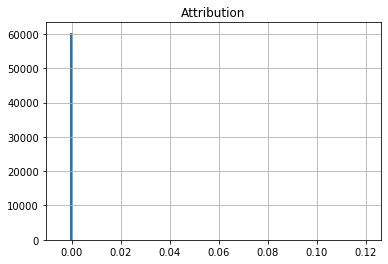

In [60]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

In [61]:
pdist = torch.nn.PairwiseDistance(p=2)
outdist = pdist(exp_data, ctrl_data)

diff = np.round(outdist.detach().numpy() - attr.sum(axis=1), 3)
diff.mean(); np.median(diff); diff.var()

1542.4308

624.59705

9738661.0

In [62]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)

0
ENSG00000229028.2    0.029883
ENSG00000187242.4    0.013449
ENSG00000236957.6    0.008771
ENSG00000277969.1    0.008113
ENSG00000228221.4    0.006264
ENSG00000226374.1    0.006105
ENSG00000169962.4    0.005730
ENSG00000263433.1    0.004890
ENSG00000280707.1    0.004355
ENSG00000249082.2    0.003805
dtype: float32

0
ENSG00000215182.8     0.419643
ENSG00000096006.10    0.033312
ENSG00000143512.11    0.006348
ENSG00000226707.1     0.004333
ENSG00000260459.2     0.003920
ENSG00000188997.6     0.003187
ENSG00000244619.2     0.002994
ENSG00000260963.1     0.002989
ENSG00000263566.1     0.002446
ENSG00000223018.1     0.002219
dtype: float32

0
ENSG00000232188.1     0.185230
ENSG00000237256.1     0.114815
ENSG00000167165.17    0.063186
ENSG00000274246.1     0.039976
ENSG00000243135.4     0.039093
ENSG00000224718.1     0.018678
ENSG00000253819.1     0.012657
ENSG00000188690.11    0.012289
ENSG00000248114.1     0.011921
ENSG00000107949.15    0.011558
dtype: float32

0
ENSG00000229755.1     0.008028
ENSG00000226975.1     0.004327
ENSG00000215943.1     0.003822
ENSG00000226547.2     0.003685
ENSG00000230268.3     0.003092
ENSG00000204983.11    0.003059
ENSG00000232294.4     0.002933
ENSG00000223629.1     0.002741
ENSG00000244067.2     0.002458
ENSG00000168703.5     0.002318
dtype: float32

0
ENSG00000105550.7     0.058185
ENSG00000131737.5     0.056672
ENSG00000111700.11    0.030897
ENSG00000126550.7     0.025826
ENSG00000255271.1     0.013981
ENSG00000121634.5     0.009187
ENSG00000233085.4     0.007998
ENSG00000279458.1     0.007626
ENSG00000233532.4     0.006968
ENSG00000140522.10    0.005431
dtype: float32

0
ENSG00000215182.8     0.419643
ENSG00000096006.10    0.033312
ENSG00000143512.11    0.006348
ENSG00000226707.1     0.004333
ENSG00000260459.2     0.003920
ENSG00000188997.6     0.003187
ENSG00000244619.2     0.002994
ENSG00000260963.1     0.002989
ENSG00000263566.1     0.002446
ENSG00000223018.1     0.002219
dtype: float32

0
ENSG00000230014.1    0.548408
ENSG00000271307.1    0.423718
ENSG00000274269.1    0.073200
ENSG00000241280.1    0.046496
ENSG00000280140.1    0.042154
ENSG00000228695.8    0.029080
ENSG00000215811.5    0.017028
ENSG00000237617.1    0.016209
ENSG00000215612.6    0.015500
ENSG00000182459.4    0.014678
dtype: float32

0
ENSG00000249557.2     1.678962
ENSG00000233258.1     0.051050
ENSG00000229982.1     0.047050
ENSG00000254842.5     0.043771
ENSG00000225537.1     0.025994
ENSG00000186493.10    0.014763
ENSG00000222418.1     0.014112
ENSG00000149972.9     0.013901
ENSG00000279773.1     0.012599
ENSG00000168229.3     0.011339
dtype: float32

0
ENSG00000230339.2    0.008288
ENSG00000275508.1    0.004623
ENSG00000199158.1    0.004040
ENSG00000236303.2    0.002995
ENSG00000264545.1    0.002834
ENSG00000186970.4    0.002493
ENSG00000277212.1    0.002433
ENSG00000271894.1    0.002295
ENSG00000273561.1    0.001792
ENSG00000249016.1    0.001778
dtype: float32

0
ENSG00000268089.2     0.032125
ENSG00000215644.8     0.017636
ENSG00000249082.2     0.011888
ENSG00000231694.1     0.010982
ENSG00000241244.1     0.010227
ENSG00000277683.1     0.009664
ENSG00000276348.1     0.009349
ENSG00000253818.1     0.008456
ENSG00000181588.16    0.007201
ENSG00000280412.1     0.007117
dtype: float32

0
ENSG00000263566.1    0.002381
ENSG00000270242.1    0.001646
ENSG00000201923.1    0.001399
ENSG00000250688.1    0.001312
ENSG00000182634.7    0.001311
ENSG00000278568.1    0.001243
ENSG00000237242.1    0.001162
ENSG00000200839.1    0.000987
ENSG00000207101.1    0.000887
ENSG00000229142.1    0.000790
dtype: float32

0
ENSG00000210741.1     0.064113
ENSG00000123838.9     0.030747
ENSG00000234427.1     0.017399
ENSG00000185269.10    0.016442
ENSG00000258844.1     0.011952
ENSG00000252697.1     0.011823
ENSG00000125084.10    0.011097
ENSG00000253262.1     0.010738
ENSG00000259889.1     0.010566
ENSG00000237266.1     0.010417
dtype: float32

0
ENSG00000258991.1    0.453016
ENSG00000258567.1    0.218308
ENSG00000221747.1    0.174298
ENSG00000274773.1    0.141500
ENSG00000277716.1    0.104610
ENSG00000276079.1    0.093463
ENSG00000273534.1    0.056514
ENSG00000144771.7    0.047131
ENSG00000215545.1    0.042715
ENSG00000259554.1    0.034021
dtype: float32

0
ENSG00000251454.1     0.018451
ENSG00000226321.5     0.006725
ENSG00000248646.1     0.004509
ENSG00000241317.1     0.004383
ENSG00000246016.2     0.003901
ENSG00000241102.1     0.003766
ENSG00000164287.11    0.003721
ENSG00000139445.16    0.003719
ENSG00000280119.1     0.003224
ENSG00000163060.7     0.003125
dtype: float32

0
ENSG00000229755.1     0.008028
ENSG00000226975.1     0.004327
ENSG00000215943.1     0.003822
ENSG00000226547.2     0.003685
ENSG00000230268.3     0.003092
ENSG00000204983.11    0.003059
ENSG00000232294.4     0.002933
ENSG00000223629.1     0.002741
ENSG00000244067.2     0.002458
ENSG00000168703.5     0.002318
dtype: float32

0
ENSG00000263566.1    0.002381
ENSG00000270242.1    0.001646
ENSG00000201923.1    0.001399
ENSG00000250688.1    0.001312
ENSG00000182634.7    0.001311
ENSG00000278568.1    0.001243
ENSG00000237242.1    0.001162
ENSG00000200839.1    0.000987
ENSG00000207101.1    0.000887
ENSG00000229142.1    0.000790
dtype: float32

0
ENSG00000124812.13    0.152121
ENSG00000268751.1     0.033962
ENSG00000223648.3     0.027451
ENSG00000280707.1     0.011522
ENSG00000267094.1     0.011480
ENSG00000226707.1     0.011070
ENSG00000256148.1     0.007685
ENSG00000276951.1     0.006755
ENSG00000210741.1     0.005779
ENSG00000278982.1     0.004737
dtype: float32

0
ENSG00000089116.3     0.021884
ENSG00000156510.12    0.020825
ENSG00000258381.1     0.016083
ENSG00000128714.5     0.012417
ENSG00000117148.7     0.010680
ENSG00000172116.20    0.009978
ENSG00000248656.1     0.009570
ENSG00000238266.1     0.007889
ENSG00000211662.2     0.007523
ENSG00000242486.1     0.007336
dtype: float32

0
ENSG00000259094.1    0.042082
ENSG00000224789.1    0.004113
ENSG00000211649.3    0.003976
ENSG00000241149.2    0.003473
ENSG00000280298.1    0.003456
ENSG00000255079.1    0.003455
ENSG00000211933.2    0.003398
ENSG00000211668.2    0.002980
ENSG00000267978.4    0.002658
ENSG00000240864.3    0.002281
dtype: float32

0
ENSG00000105550.7     0.058185
ENSG00000131737.5     0.056672
ENSG00000111700.11    0.030897
ENSG00000126550.7     0.025826
ENSG00000255271.1     0.013981
ENSG00000121634.5     0.009187
ENSG00000233085.4     0.007998
ENSG00000279458.1     0.007626
ENSG00000233532.4     0.006968
ENSG00000140522.10    0.005431
dtype: float32

0
ENSG00000263566.1    0.002381
ENSG00000270242.1    0.001646
ENSG00000201923.1    0.001399
ENSG00000250688.1    0.001312
ENSG00000182634.7    0.001311
ENSG00000278568.1    0.001243
ENSG00000237242.1    0.001162
ENSG00000200839.1    0.000987
ENSG00000207101.1    0.000887
ENSG00000229142.1    0.000790
dtype: float32

0
ENSG00000230628.1    0.011931
ENSG00000180424.6    0.008690
ENSG00000264092.2    0.006261
ENSG00000228044.2    0.005727
ENSG00000239028.1    0.005397
ENSG00000270962.1    0.004467
ENSG00000200390.1    0.004273
ENSG00000263639.4    0.004193
ENSG00000240270.1    0.004010
ENSG00000258576.1    0.003861
dtype: float32

0
ENSG00000259094.1    0.042082
ENSG00000224789.1    0.004113
ENSG00000211649.3    0.003976
ENSG00000241149.2    0.003473
ENSG00000280298.1    0.003456
ENSG00000255079.1    0.003455
ENSG00000211933.2    0.003398
ENSG00000211668.2    0.002980
ENSG00000267978.4    0.002658
ENSG00000240864.3    0.002281
dtype: float32

0
ENSG00000249557.2     1.678962
ENSG00000233258.1     0.051050
ENSG00000229982.1     0.047050
ENSG00000254842.5     0.043771
ENSG00000225537.1     0.025994
ENSG00000186493.10    0.014763
ENSG00000222418.1     0.014112
ENSG00000149972.9     0.013901
ENSG00000279773.1     0.012599
ENSG00000168229.3     0.011339
dtype: float32

0
ENSG00000230628.1    0.011931
ENSG00000180424.6    0.008690
ENSG00000264092.2    0.006261
ENSG00000228044.2    0.005727
ENSG00000239028.1    0.005397
ENSG00000270962.1    0.004467
ENSG00000200390.1    0.004273
ENSG00000263639.4    0.004193
ENSG00000240270.1    0.004010
ENSG00000258576.1    0.003861
dtype: float32

0
ENSG00000229755.1     0.008028
ENSG00000226975.1     0.004327
ENSG00000215943.1     0.003822
ENSG00000226547.2     0.003685
ENSG00000230268.3     0.003092
ENSG00000204983.11    0.003059
ENSG00000232294.4     0.002933
ENSG00000223629.1     0.002741
ENSG00000244067.2     0.002458
ENSG00000168703.5     0.002318
dtype: float32

0
ENSG00000251454.1     0.018451
ENSG00000226321.5     0.006725
ENSG00000248646.1     0.004509
ENSG00000241317.1     0.004383
ENSG00000246016.2     0.003901
ENSG00000241102.1     0.003766
ENSG00000164287.11    0.003721
ENSG00000139445.16    0.003719
ENSG00000280119.1     0.003224
ENSG00000163060.7     0.003125
dtype: float32

0
ENSG00000253345.1    0.009083
ENSG00000232216.1    0.007917
ENSG00000258224.1    0.007500
ENSG00000253497.1    0.006923
ENSG00000253860.1    0.004712
ENSG00000276566.1    0.004562
ENSG00000260406.1    0.004080
ENSG00000211951.2    0.003779
ENSG00000241566.1    0.003334
ENSG00000211668.2    0.003302
dtype: float32